## Get all the imports 

Enter company ticker you want search for?  BHP
TTM


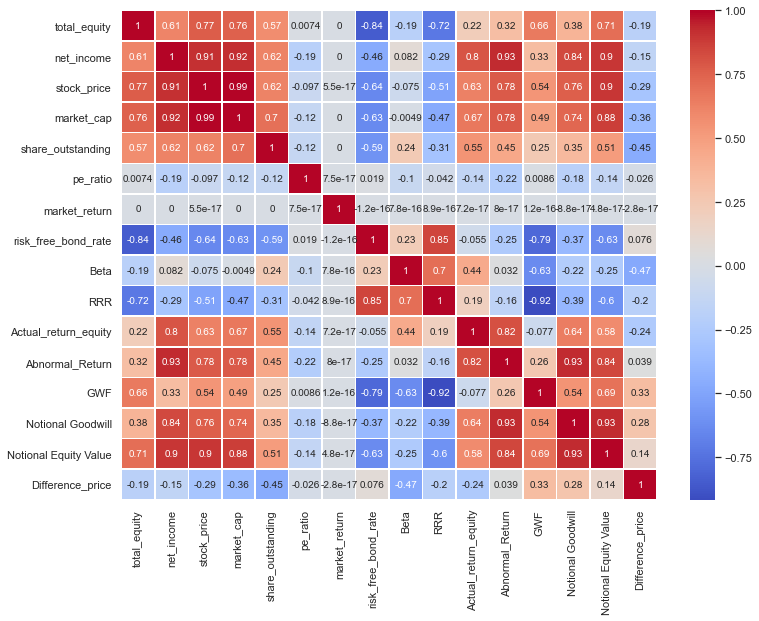

TypeError: <lambda>() got an unexpected keyword argument 'axis'

In [7]:
import requests
import json
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import plotly
import cufflinks as cf
from plotly.offline import download_plotlyjs,init_notebook_mode,plot,iplot
import os
from pprint import pprint
#sql config




init_notebook_mode(connected=True)
cf.go_offline()
name = str(input("Enter company ticker you want search for?  "))

CA_FILE = "./cacert.pem"
API_KEY = os.environ.get('GURU_FOCUS_API')
COMPANY_TICKER = 'ASX:{}'.format(name)
DETAILS = 'financials'
MARKET_RETURN = 0.065

RISK_FREE_BOND ={'1969': 0.058,
 '1970': 0.0689,
 '1971': 0.0681,
 '1972': 0.058,
 '1973': 0.0674,
 '1974': 0.095,
 '1975': 0.1,
 '1976': 0.1,
 '1977': 0.1041,
 '1978': 0.091,
 '1979': 0.1007,
 '1980': 0.1178,
 '1981': 0.139,
 '1982': 0.164,
 '1983': 0.148,
 '1984': 0.1315,
 '1985': 0.134,
 '1986': 0.142,
 '1987': 0.1295,
 '1988': 0.1195,
 '1989': 0.1335,
 '1990': 0.1316,
 '1991': 0.1099,
 '1992': 0.083,
 '1993': 0.0688,
 '1994': 0.0957,
 '1995': 0.0908,
 '1996': 0.0863,
 '1997': 0.0664,
 '1998': 0.0552,
 '1999': 0.0614,
 '2000': 0.0616,
 '2001': 0.0609,
 '2002': 0.0586,
 '2003': 0.0523,
 '2004': 0.0572,
 '2005': 0.0519,
 '2006': 0.0583,
 '2007': 0.0615,
 '2008': 0.0637,
 '2009': 0.0549,
 '2010': 0.0515,
 '2011': 0.0502,
 '2012': 0.0289,
 '2013': 0.0375,
 '2014': 0.034675,
 '2015': 0.029025,
 '2016': 0.019275,
 '2017': 0.026425,
 '2018': 0.0264,
 '2019': 0.0131,
 '2020': 0.0088}



def get_data(COMPANY_TICKER):
    URL = f"https://api.gurufocus.com/public/user/{API_KEY}/stock/{COMPANY_TICKER}/{DETAILS}"
    response = requests.get(URL,verify=CA_FILE).json()
    return response
    
def create_statements():
        data_new = get_data(COMPANY_TICKER)
        header_keys = data_new['financials'] ['annuals'].keys()
        years = data_new['financials'] ['annuals']['Fiscal Year']
        years = [x.split('-')[0] for x in years]
        number_of_years = len(years[:-1])
        #checking if last year matches the bond rate value
        print(years[-1])
        if(years[-1] == 'TTM'):
            
            if years[-2] ==  list(RISK_FREE_BOND.keys())[-1]:
                
                RISK_FREE_BOND_X =  list(RISK_FREE_BOND.values())[-1::-1]
                RISK_FREE_BOND_X.insert(0, 0)
                
            else:
                
                RISK_FREE_BOND_X = list(RISK_FREE_BOND.values())[-2::-1]
                RISK_FREE_BOND_X.insert(0, 0)
        else:
              if years[-1] ==  list(RISK_FREE_BOND.keys())[-1]:
                
                RISK_FREE_BOND_X =  list(RISK_FREE_BOND.values())[-1::-1]
              else:
                
                RISK_FREE_BOND_X = list(RISK_FREE_BOND.values())[-2::-1]
                
                
        total_equity = data_new['financials']['annuals']['balance_sheet']['Total Equity']
        net_income = data_new['financials']['annuals']['income_statement']['Net Income (Continuing Operations)']
        stock_price = data_new['financials']['annuals']['per_share_data_array']['Month End Stock Price']
        market_cap = data_new['financials']['annuals']['valuation_and_quality']['Market Cap']
        share_outstanding = data_new['financials']['annuals']['valuation_and_quality']['Shares Outstanding (EOP)']
        beta = data_new['financials']['annuals']['valuation_and_quality']['Beta']
        pe_ratio = data_new['financials']['annuals']['valuation_ratios']['PE Ratio']
        return total_equity,net_income,stock_price,market_cap,share_outstanding,pe_ratio,years,beta,RISK_FREE_BOND_X
          
def create_df():

    total_equity,net_income,stock_price,market_cap,share_outstanding,pe_ratio,years,beta,RISK_FREE_BOND_X = create_statements()
    df = pd.DataFrame({ 'total_equity':total_equity,
                           'net_income':net_income,
                          'stock_price':stock_price,
                           'market_cap':market_cap,
                           'share_outstanding':share_outstanding,
                           'pe_ratio':pe_ratio,
                           'market_return':[ MARKET_RETURN for x  in range(len(years))],
                           'risk_free_bond_rate': list(reversed(RISK_FREE_BOND_X[:len(years)])),
                           'Beta':beta

    },index = years)
    df = df.iloc[:-1,:]
    df = df.dropna()
    
    return df


df = create_df()
df.fillna(0,inplace = True)
df = df.applymap(lambda x: 0 if x == '-' else x )
df = df.astype('float')
df['RRR'] = df['risk_free_bond_rate']+(df['Beta']*df['market_return'])
df.loc[:,['net_income','total_equity','market_cap','share_outstanding']] =df[['net_income','total_equity','market_cap','share_outstanding']].apply(lambda x: x*1000000)
df['Actual_return_equity'] = (df['net_income']/df['total_equity'])
df['Abnormal_Return'] = df['total_equity']*(df['Actual_return_equity']-df['RRR'])
df['GWF']=  (1/ df['RRR'])         
df['Notional Goodwill'] = (df['Abnormal_Return']*df['GWF'])
df['Notional Equity Value'] = df['total_equity'] + df['Notional Goodwill']
df['Difference_price'] = df['Notional Equity Value'] - df['market_cap'] 


%matplotlib inline
plt.figure(figsize=(12,9))
corr = df.corr()
sns.heatmap(corr,annot = True, linewidth=0.5,cmap = 'coolwarm')
plt.show()
# result[['stock_price','Advali_Notional_Stock_Price']].iplot(kind='line')
df['stock_price'].iplot(kind='line',xTitle='Year',yTitle='Stock Price',title='Stock Price Difference')

In [8]:
df['stock_price'].iplot(kind='line',xTitle='Year',yTitle='Stock Price',title='Stock Price Difference')

In [9]:
df

,total_equity,net_income,stock_price,market_cap,share_outstanding,pe_ratio,market_return,risk_free_bond_rate,Beta,RRR,Actual_return_equity,Abnormal_Return,GWF,Notional Goodwill,Notional Equity Value,Difference_price
1991,6.811961e+09,1.398153e+09,4.71,1.462676e+10,3.105470e+09,10.40,0.065,0.109900,1.10,0.181400,0.205250,1.624633e+08,5.512679,8.956079e+08,7.707569e+09,-6.919195e+09
1992,8.416926e+09,5.159700e+08,5.46,1.788942e+10,3.276450e+09,26.65,0.065,0.083000,1.03,0.149950,0.061301,-7.461481e+08,6.668890,-4.975979e+09,3.440947e+09,-1.444847e+10
1993,1.104560e+10,1.173420e+09,5.37,1.826777e+10,3.401820e+09,12.11,0.065,0.068800,1.14,0.142900,0.106234,-4.049967e+08,6.997901,-2.834126e+09,8.211477e+09,-1.005630e+10
1994,1.316010e+10,1.307531e+09,6.91,2.414416e+10,3.494090e+09,14.56,0.065,0.095700,1.30,0.180200,0.099356,-1.063919e+09,5.549390,-5.904102e+09,7.255999e+09,-1.688816e+10
1995,1.461419e+10,1.200100e+09,7.35,2.407500e+10,3.275510e+09,19.55,0.065,0.090800,1.30,0.175300,0.082119,-1.361767e+09,5.704507,-7.768209e+09,6.845978e+09,-1.722902e+10
1996,1.577937e+10,1.048176e+09,7.85,2.614647e+10,3.330760e+09,24.85,0.065,0.086300,1.24,0.166900,0.066427,-1.585400e+09,5.991612,-9.499102e+09,6.280264e+09,-1.986620e+10
1997,1.595859e+10,4.037700e+08,7.86,2.679254e+10,3.408720e+09,69.94,0.065,0.066400,1.23,0.146350,0.025301,-1.931770e+09,6.832935,-1.319966e+10,2.758934e+09,-2.403360e+10
1998,1.230451e+10,-1.462032e+09,5.69,2.004712e+10,3.523220e+09,0.00,0.065,0.055200,1.00,0.120200,-0.118821,-2.941034e+09,8.319468,-2.446784e+10,-1.216333e+10,-3.221045e+10
1999,9.221499e+09,-2.277081e+09,6.44,2.319076e+10,3.601050e+09,0.00,0.065,0.061400,1.02,0.127700,-0.246932,-3.454666e+09,7.830854,-2.705299e+10,-1.783149e+10,-4.102225e+10
2000,1.104585e+10,3.967160e+08,8.21,3.034375e+10,3.695950e+09,44.81,0.065,0.061600,1.12,0.134400,0.035915,-1.087846e+09,7.440476,-8.094095e+09,2.951756e+09,-2.739199e+10
